In [1]:
%cd ..

/Users/Marie/code/MarieMCodes/re_value_predictor


/Users/Marie/.pyenv/versions/3.10.6/envs/re_value_predictor/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### imports

In [ ]:
import pandas as pd
import numpy as np
from project_code.preprocessor import preprocess_fit_X, split_data, feature_target
from project_code.model import initialize_model, compile_model, train_model, evaluate_model

from tensorflow.keras.models import save_model, load_model
import pickle

In [10]:
import matplotlib.pyplot as plt
%%timeit 

### Model 1: concise data, all years

#### Run model

In [128]:
def run_initial_training(data):
    """
    runs initial training: from loading data, processing it, splitting data,
    instantiating model, compiling, training and evaluating.
    Output MAE and MSE
    """
    #data=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
   #                 dtype={'price': np.int32,'month':np.int16,'year':np.int16},
    #                ).sample(600000)
    # master: drop month, drop date
    #data.drop(columns=['date','month'],inplace=True)

    # remove premium price outliers and too low house prices
    clean_data=data[(data['price']<1500000) & (data['price']>299000)]
    print('✅ data loaded and cleaned')

    # split X and y and take log of y
    X,y=feature_target(clean_data)
    # split the X and y
    X_train, X_test, y_train, y_test= split_data(X,y)
    print('✅ data split')

    # fit preprocessor on training set
    preprocessor_fitted=preprocess_fit_X(X_train)
    print(" ✅ X_train fitted and saved preprocessor")

    # Export processor as pickle file
    with open("models/preprocessor_model1concise.pkl","wb") as file:
        pickle.dump(preprocessor_fitted, file)

    # transfrom X_train,X_test
    X_train_processed= preprocessor_fitted.transform(X_train)
    X_test_processed= preprocessor_fitted.transform(X_test)
    print(f'✅ X_train processed with shape {X_train_processed.shape}')
    print(f'✅ X_test processed with shape {X_test_processed.shape}')


    # initialise_model
    model=initialize_model()

    # compile_model
    model=compile_model(model)

    # train_model
    model=train_model(model,X_train_processed,y_train)[0]
    print('✅ model finished training')

    #save model
    save_model(model, 'models/model_1concise.h5')
    print('✅ model saved ')

    # evaluate
    mae, mse=evaluate_model(model,X_test_processed,y_test)
    print(f'MAE is {mae}, and MSE is {mse}. Training is complete')
    return  mae,mse,data,model,X_test_processed,y_test


# def prediction(year=2023,
#     property_type='F',
#     property_age='N',
#     ownership='L',
#     lat=51.5487553,
#     lon=-0.1235217,
#     sin_time=-0.5,
#     cos_time=-0.866025):
    
def prediction(X):
    """
    takes new X, processes them and predicts
    """
    #X_new=pd.DataFrame(locals(),index=[0])
    X_new=pd.DataFrame(X, index=[0])
    print(f"✅ new data loaded in df with shape {X_new.shape}")

    # load preprocessor
    preprocessor=pickle.load(open("models/preprocessor_model1concise.pkl","rb"))
    X_new_processed=preprocessor.transform(X_new)
    print(f"✅ new data processed with shape {X_new_processed.shape}")

    #load model
    model=load_model('models/model_1concise.h5')
    print("✅ model loaded")

    # predict
    ypred=model.predict(X_new_processed)
    print("✅ model predicted")

    # reverse log price to actual price
    prediction=np.exp(ypred)
    print(f" Your predicted price for the property is: {prediction}")
    return prediction


In [56]:
%timeit 
mae,mse,data,model_1,X_test_processed_1,y_test_1=run_initial_training()
print(f'mae is{mae}, mse is{mse}')

✅ data loaded and cleaned
✅ data split


/Users/Marie/code/MarieMCodes/re_value_predictor/project_code/preprocessor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_return'] = np.log(df['price'])


 ✅ X_train fitted and saved preprocessor
✅ X_train processed with shape (298104, 11)
✅ X_test processed with shape (74526, 11)
✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping
✅ Model trained on 298104 rows with min val MAE: 0.21
✅ model finished training
✅ model saved 
2329/2329 [==============================] - 4s 2ms/step - loss: 0.0760 - mae: 0.2132
Mean Absolute Error (MAE): 0.2132100611925125
Mean Squared Error (MSE): 0.07597144693136215
MAE is 0.2132100611925125, and MSE is 0.07597144693136215. Training is complete
mae is0.2132100611925125, mse is0.07597144693136215


In [129]:

X_new={'year':2018,
    'property_type':'F',
    'property_age':'N',
    'ownership':'L',
    'lat':51.5487553,
    'lon':-0.1235217,
    'sin_time':-0.5,
    'cos_time':-0.866025}

prediction=prediction(X_new)
prediction

✅ new data loaded in df with shape (1, 8)
✅ new data processed with shape (1, 11)
✅ model loaded
1/1 [==============================] - 0s 137ms/step
✅ model predicted
 Your predicted price for the property is: [[498776.4]]


array([[498776.4]], dtype=float32)

#### Run prediction of X_test and compare visually

In [66]:
# plotting both logged prediction against logged ytest
ypred_1=model_1.predict(X_test_processed_1)
ypred_1

2329/2329 [==============================] - 4s 1ms/step


array([[13.072778],
       [13.413399],
       [12.863276],
       ...,
       [13.210253],
       [13.013265],
       [12.87164 ]], dtype=float32)

(12.5, 14.5)

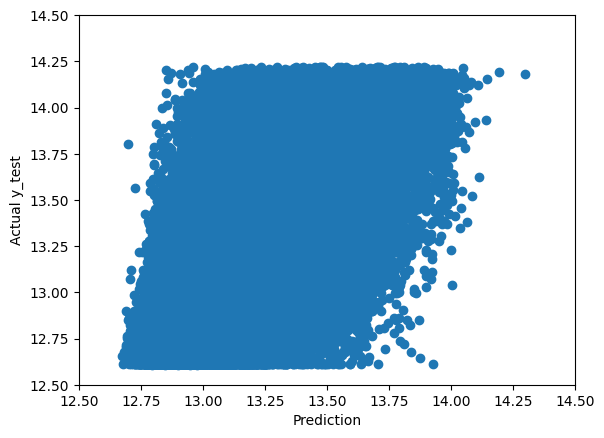

In [71]:
plt.scatter(x=ypred_1, y=y_test_1)
plt.xlabel('Prediction')
plt.ylabel('Actual y_test')
plt.ylim(12.5,14.5)
plt.xlim(12.5,14.5)

In [75]:
# convert prices to actual pounds values
ypred_1_exp=np.exp(ypred_1)
y_test_1_exp=np.exp(y_test_1)

(0.0, 6000000.0)

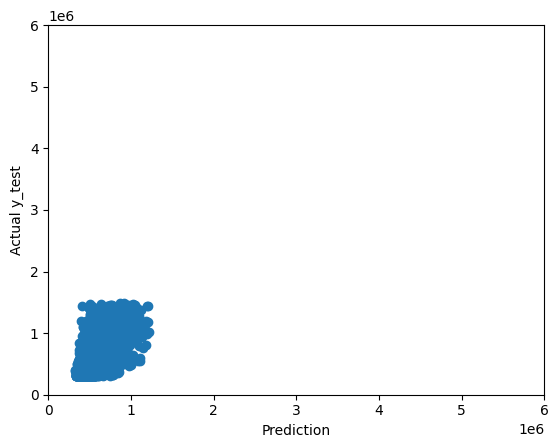

In [108]:
# showing first 5000 rows of actual vs predicted prices
plt.scatter(x=ypred_1_exp[:5000], y=y_test_1_exp[:5000])
plt.xlabel('Prediction')
plt.ylabel('Actual y_test')
plt.ylim(0,6000000)
plt.xlim(0,6000000)

### Model 2: alldata, recent years

#### Explore recent data and price outliers

In [57]:
data_reduced=data[data['price']<8000000]
data_reduced

,price,property_type,property_age,ownership,year,lat,lon,sin_time,cos_time
1312570,232000,F,N,L,2015,51.641988,-0.009105,5.000000e-01,8.660254e-01
1067345,445000,S,N,F,2013,51.382595,-0.234050,-1.000000e+00,-1.836970e-16
1953821,365000,F,N,L,2022,51.458681,-0.018031,5.000000e-01,-8.660254e-01
620865,337616,F,Y,L,2007,51.564986,-0.336012,8.660254e-01,5.000000e-01
1205673,255000,F,N,L,2014,51.524391,-0.176083,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...
389032,340000,F,N,L,2004,51.475728,-0.154524,-5.000000e-01,8.660254e-01
1458694,297000,T,N,F,2017,51.560195,0.177977,8.660254e-01,-5.000000e-01
2043966,248000,F,N,L,2009,51.387975,-0.102388,-8.660254e-01,5.000000e-01
2142635,390000,S,N,F,2009,51.585648,-0.102388,-5.000000e-01,-8.660254e-01


(0.0, 8000000.0)

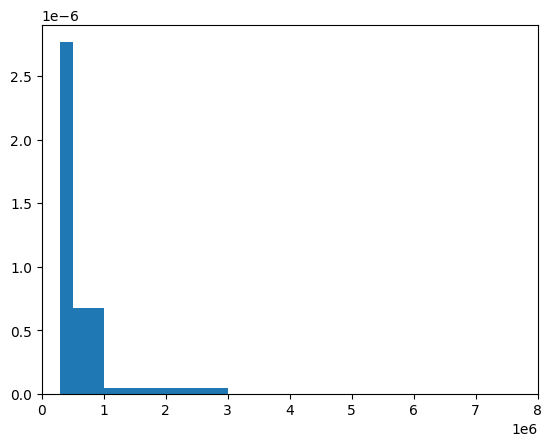

In [31]:
# first evaluate true outliers from data, look at histogram
plt.hist(x=data_reduced['price'],bins=[300000,500000,1000000,3000000,5000000,8000000,11000000],density=True)
plt.xlim(0,11000000)

In [54]:
# def. keep 4 million in. evaluate how many properties are btw 4 and 6 ml
#data[(data['price']>4000000)&(data['price']<6000000)] # 1400 rows
#data[(data['price']>5000000)&(data['price']<6000000)]  # 464 rows
data[(data['price']>5000000)] # excluding 1410 properties out of 600k = 0.2% 


,price,property_type,property_age,ownership,year,lat,lon,sin_time,cos_time
1236413,10800000,D,N,F,2015,51.573907,-0.165920,-8.660254e-01,-0.500000
1338645,8860000,F,N,L,2016,51.500818,-0.182168,1.224647e-16,-1.000000
1867872,6350000,F,N,L,2021,51.504094,-0.198666,-2.449294e-16,1.000000
1923103,8500000,S,N,F,2022,51.485983,-0.178308,8.660254e-01,0.500000
1705837,7040000,T,N,F,2020,51.522516,-0.149952,-8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...
1619613,8800000,S,N,F,2019,51.570151,-0.175912,8.660254e-01,-0.500000
762560,5250000,T,N,F,2009,51.498924,-0.160421,-8.660254e-01,0.500000
1302308,10100000,F,Y,L,2015,51.499803,-0.185724,-5.000000e-01,-0.866025
2055967,9000000,D,N,F,2012,51.541190,-0.102388,1.224647e-16,-1.000000


In [79]:
# look at price data only since 2009
data_recent=data[data['year']>2009]
data_recent.describe()

,price,year,lat,lon,sin_time,cos_time
count,3.528910e+05,352891.000000,352891.000000,352891.000000,3.528910e+05,3.528910e+05
mean,5.940703e+05,2016.353174,51.499407,-0.118100,-2.812014e-02,-1.398063e-02
std,6.361280e+05,3.636158,0.075106,0.143591,7.091146e-01,7.043956e-01
min,2.000000e+05,2010.000000,51.293401,-0.498166,-1.000000e+00,-1.000000e+00
25%,3.175000e+05,2013.000000,51.447037,-0.203605,-8.660254e-01,-8.660254e-01
50%,4.350000e+05,2016.000000,51.499518,-0.106983,-2.449294e-16,-1.836970e-16
75%,6.350000e+05,2019.000000,51.556050,-0.027142,5.000000e-01,5.000000e-01
max,1.490000e+07,2023.000000,51.687047,0.309380,1.000000e+00,1.000000e+00


(0.0, 8000000.0)

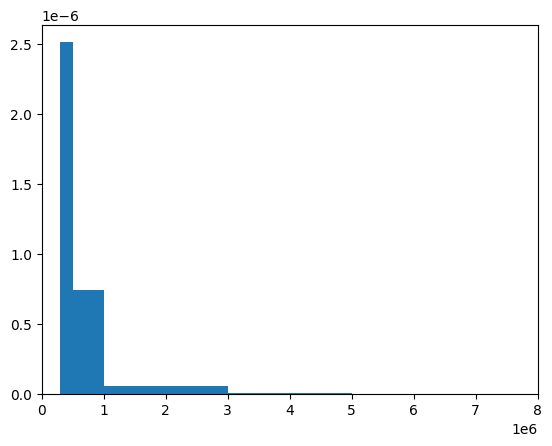

In [82]:
plt.hist(x=data_recent['price'],bins=[300000,500000,1000000,3000000,5000000,8000000],density=True)
plt.xlim(0,8000000)

In [86]:
# how many properties would we cut out beyond 8 ml?
print(len(data_recent)) # a little more than half the dataset 
data_recent[(data_recent['price']>6000000)] # at 6 ml excluding 829 = 0.2% 

352891


,price,property_type,property_age,ownership,year,lat,lon,sin_time,cos_time
1658684,14000000,F,N,L,2019,51.487483,-0.171853,1.224647e-16,-1.000000e+00
2105637,7250000,S,N,F,2020,51.508666,-0.102388,-2.449294e-16,1.000000e+00
1303845,5500000,T,N,F,2015,51.497463,-0.189693,1.224647e-16,-1.000000e+00
1305285,6950000,F,N,L,2015,51.502803,-0.200705,5.000000e-01,8.660254e-01
1823702,11950000,T,N,F,2021,51.503419,-0.208015,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...
1484196,9300000,F,N,L,2017,51.518414,-0.144573,-2.449294e-16,1.000000e+00
1393265,9030751,F,N,L,2016,51.512887,-0.169539,1.000000e+00,6.123234e-17
900908,9950000,T,N,F,2011,51.500418,-0.197039,8.660254e-01,-5.000000e-01
1182547,6250000,D,N,F,2014,51.557613,-0.186772,5.000000e-01,8.660254e-01


#### Run model

In [133]:
def run_initial_training2(data):
    """
    uses all data but only since 2010
    runs initial training: from loading data, splitting data, fitting and processing
    instantiating model, compiling, training and evaluating.
    Output MAE and MSE
    """
    #data=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
    #                dtype={'price': np.int32,'month':np.int16,'year':np.int16},
    #                ).sample(600000)
    # master: drop month, drop date
    #data.drop(columns=['date','month'],inplace=True)

    # remove  price outliers (anything 6ml or above) and data before 2010
    #clean_data=data[(data['year']>2009) & (data['price']<6000000)]
    clean_data=data[(data['price']>199000) & (data['price']<3500000)]
    print('✅ data loaded and cleaned')

    X,y=feature_target(clean_data)
    # split the X and y
    X_train, X_test, y_train, y_test= split_data(X,y)
    print('✅ data split')

    # fit preprocessor on training set
    preprocessor_fitted=preprocess_fit_X(X_train)
    print(" ✅ X_train fitted and saved preprocessor")

    # Export processor as pickle file
    with open("models/preprocessor_model2recent.pkl","wb") as file:
        pickle.dump(preprocessor_fitted, file)

    # transfrom X_train,X_test
    X_train_processed= preprocessor_fitted.transform(X_train)
    X_test_processed= preprocessor_fitted.transform(X_test)
    print(f'✅ X_train processed with shape {X_train_processed.shape}')
    print(f'✅ X_test processed with shape {X_test_processed.shape}')


    # initialise_model
    model=initialize_model()

    # compile_model
    model=compile_model(model)

    # train_model
    model=train_model(model,X_train_processed,y_train)[0]
    print('✅ model finished training')

    #save model
    save_model(model, 'models/model_3recent.h5')
    print('✅ model saved ')

    # evaluate
    mae, mse=evaluate_model(model,X_test_processed,y_test)
    print(f'MAE is {mae}, and MSE is {mse}. Training is complete')
    return  mae,mse,model,X_test_processed,y_test


# def prediction(year=2023,
#     property_type='F',
#     property_age='N',
#     ownership='L',
#     lat=51.5487553,
#     lon=-0.1235217,
#     sin_time=-0.5,
#     cos_time=-0.866025):
    
def prediction2(X):
    """
    takes new X, processes them and predicts
    """
    #X_new=pd.DataFrame(locals(),index=[0])
    X_new=pd.DataFrame(X, index=[0])
    print(f"✅ new data loaded in df with shape {X_new.shape}")

    # load preprocessor
    preprocessor=pickle.load(open("models/preprocessor_model2recent.pkl","rb"))
    X_new_processed=preprocessor.transform(X_new)
    print(f"✅ new data processed with shape {X_new_processed.shape}")

    #load model
    model=load_model('models/model_3recent.h5')
    print("✅ model loaded")

    # predict
    ypred=model.predict(X_new_processed)
    print("✅ model predicted")

    # reverse log price to actual price
    prediction=np.exp(ypred)
    print(f" Your predicted price for the property is: {prediction}")
    return prediction


In [134]:
%timeit  
mae,mse,model_2,X_test_processed_2,y_test_2=run_initial_training2(data)
print(f'mae is{mae}, mse is{mse}')

✅ data loaded and cleaned


/Users/Marie/code/MarieMCodes/re_value_predictor/project_code/preprocessor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_return'] = np.log(df['price'])


✅ data split
 ✅ X_train fitted and saved preprocessor
✅ X_train processed with shape (477425, 11)
✅ X_test processed with shape (119357, 11)
✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 36.
Epoch 46: early stopping
✅ Model trained on 477425 rows with min val MAE: 0.24
✅ model finished training
✅ model saved 
3730/3730 [==============================] - 6s 2ms/step - loss: 0.1066 - mae: 0.2390
Mean Absolute Error (MAE): 0.23904381692409515
Mean Squared Error (MSE): 0.10656095296144485
MAE is 0.23904381692409515, and MSE is 0.10656095296144485. Training is complete
mae is0.23904381692409515, mse is0.10656095296144485


In [136]:
X_new={'year':2023,
    'property_type':'F',
    'property_age':'N',
    'ownership':'L',
    'lat':51.5487553,
    'lon':-0.1235217,
    'sin_time':-0.5,
    'cos_time':-0.866025}

prediction=prediction2(X_new)
prediction

✅ new data loaded in df with shape (1, 8)
✅ new data processed with shape (1, 11)
✅ model loaded
1/1 [==============================] - 0s 204ms/step
✅ model predicted
 Your predicted price for the property is: [[524947.2]]


array([[524947.2]], dtype=float32)

#### Run prediction of X_test against y_test

In [121]:
# plotting both logged prediction against logged ytest
ypred_2=model_2.predict(X_test_processed_2)

# convert prices to actual pounds values
ypred_2_exp=np.exp(ypred_2)
y_test_2_exp=np.exp(y_test_2)

2170/2170 [==============================] - 3s 1ms/step


(0.0, 5000000.0)

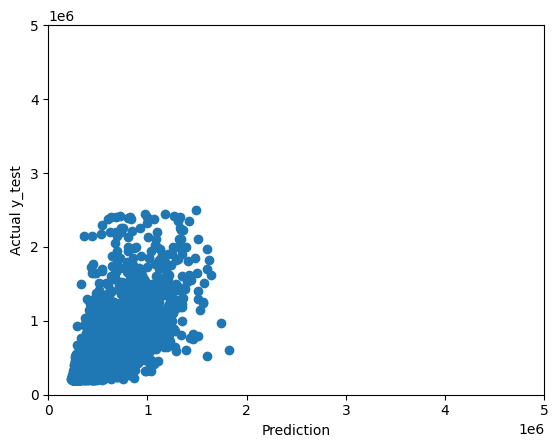

In [122]:
# showing first 5000 rows of actual vs predicted prices
plt.scatter(x=ypred_2_exp[:5000], y=y_test_2_exp[:5000])
plt.xlabel('Prediction')
plt.ylabel('Actual y_test')
plt.ylim(0,5000000)
plt.xlim(0,5000000)

### Model 3: concise data up to 1.8ml and above 249k, all years)

#### Run model

In [130]:
def run_initial_training3(data):
    """
    runs initial training: from loading data, processing it, splitting data,
    instantiating model, compiling, training and evaluating.
    Output MAE and MSE
    """
    #data=pd.read_csv('raw_data/london_re_postcodes_latlon_master.zip',
     #               dtype={'price': np.int32,'month':np.int16,'year':np.int16},
      #              ).sample(600000)
    # master: drop month, drop date
    #data.drop(columns=['date','month'],inplace=True)

    # remove premium price outliers and too low house prices
    #clean_data=data[(data['price']<3000000) & (data['price']>249000)] first run
    #clean_data=data[(data['price']<4000000) & (data['price']>249000)]
    clean_data=data[(data['price']<2500000) & (data['price']>199000)]
    print('✅ data loaded and cleaned')

    # split X and y and take log of y
    X,y=feature_target(clean_data)
    # split the X and y
    X_train, X_test, y_train, y_test= split_data(X,y)
    print('✅ data split')

    # fit preprocessor on training set
    preprocessor_fitted=preprocess_fit_X(X_train)
    print(" ✅ X_train fitted and saved preprocessor")

    # Export processor as pickle file
    with open("models/preprocessor_model4concise.pkl","wb") as file:
        pickle.dump(preprocessor_fitted, file)

    # transfrom X_train,X_test
    X_train_processed= preprocessor_fitted.transform(X_train)
    X_test_processed= preprocessor_fitted.transform(X_test)
    print(f'✅ X_train processed with shape {X_train_processed.shape}')
    print(f'✅ X_test processed with shape {X_test_processed.shape}')


    # initialise_model
    model=initialize_model()

    # compile_model
    model=compile_model(model)

    # train_model
    model=train_model(model,X_train_processed,y_train)[0]
    print('✅ model finished training')

    #save model
    save_model(model, 'models/model_4concise.h5')
    print('✅ model saved ')

    # evaluate
    mae, mse=evaluate_model(model,X_test_processed,y_test)
    print(f'MAE is {mae}, and MSE is {mse}. Training is complete')
    return  mae,mse,model,X_test_processed,y_test


# def prediction(year=2023,
#     property_type='F',
#     property_age='N',
#     ownership='L',
#     lat=51.5487553,
#     lon=-0.1235217,
#     sin_time=-0.5,
#     cos_time=-0.866025):
    
def prediction3(X):
    """
    takes new X, processes them and predicts
    """
    #X_new=pd.DataFrame(locals(),index=[0])
    X_new=pd.DataFrame(X,index=[0])
    print(f"✅ new data loaded in df with shape {X_new.shape}")

    # load preprocessor
    preprocessor=pickle.load(open("models/preprocessor_model4concise.pkl","rb"))
    X_new_processed=preprocessor.transform(X_new)
    print(f"✅ new data processed with shape {X_new_processed.shape}")

    #load model
    model=load_model('models/model_4concise.h5')
    print("✅ model loaded")

    # predict
    ypred=model.predict(X_new_processed)
    print("✅ model predicted")

    # reverse log price to actual price
    prediction=np.exp(ypred)
    print(f" Your predicted price for the property is: {prediction}")
    return prediction


In [131]:
%timeit 
mae,mse,model_3,X_test_processed_3,y_test_3=run_initial_training3(data)
print(f'mae is{mae}, mse is{mse}')

✅ data loaded and cleaned


/Users/Marie/code/MarieMCodes/re_value_predictor/project_code/preprocessor.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_return'] = np.log(df['price'])


✅ data split
 ✅ X_train fitted and saved preprocessor
✅ X_train processed with shape (474598, 11)
✅ X_test processed with shape (118650, 11)
✅ Model compiled
starting model training
Restoring model weights from the end of the best epoch: 51.
Epoch 61: early stopping
✅ Model trained on 474598 rows with min val MAE: 0.23
✅ model finished training
✅ model saved 
3708/3708 [==============================] - 6s 2ms/step - loss: 0.0994 - mae: 0.2328
Mean Absolute Error (MAE): 0.23277431726455688
Mean Squared Error (MSE): 0.09935370832681656
MAE is 0.23277431726455688, and MSE is 0.09935370832681656. Training is complete
mae is0.23277431726455688, mse is0.09935370832681656


In [137]:
%timeit 
X_new={'year':2023,
    'property_type':'F',
    'property_age':'N',
    'ownership':'L',
    'lat':51.5487553,
    'lon':-0.1235217,
    'sin_time':-0.5,
    'cos_time':-0.866025}

prediction=prediction3(X_new)
prediction

✅ new data loaded in df with shape (1, 8)
✅ new data processed with shape (1, 11)
✅ model loaded
1/1 [==============================] - 0s 403ms/step
✅ model predicted
 Your predicted price for the property is: [[544767.1]]


array([[544767.1]], dtype=float32)

#### Run plot predictions vs actual

In [106]:
# plotting both logged prediction against logged ytest
model_3=load_model('models/model_4concise.h5')
ypred_3=model_3.predict(X_test_processed_3)

# convert prices to actual pounds values
ypred_3_exp=np.exp(ypred_3)
y_test_3_exp=np.exp(y_test_3)

3005/3005 [==============================] - 4s 1ms/step


(0.0, 6000000.0)

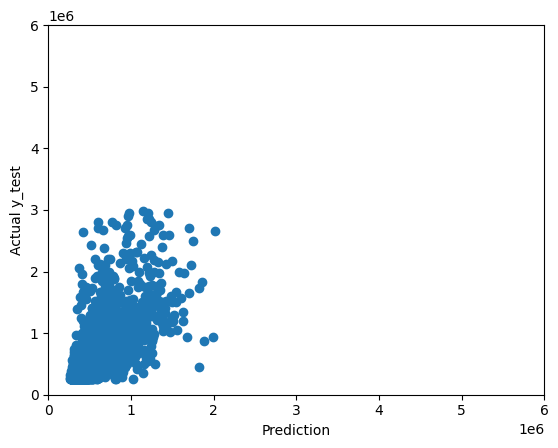

In [107]:
# showing first 5000 rows of actual vs predicted prices
plt.scatter(x=ypred_3_exp[:5000], y=y_test_3_exp[:5000])
plt.xlabel('Prediction')
plt.ylabel('Actual y_test')
plt.ylim(0,6000000)
plt.xlim(0,6000000)

In [141]:
clean_data=data[(data['price']<2500000) & (data['price']>199000)]
len(clean_data)

593248

In [139]:
len(data)

600000

In [143]:
length=1714660+428666


In [144]:
length*11

23576586